In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json

# -----------------------------
# 1️⃣ Đọc dữ liệu
# -----------------------------
grades_path = '../data/udk_moodle_grades_course_670.filtered.csv'
logs_path = '../data/udk_moodle_log_course_670.filtered.csv'

try:
    df_grades = pd.read_csv(grades_path)
    df_logs = pd.read_csv(logs_path)
except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file dữ liệu tại đường dẫn. Hãy kiểm tra lại: {e}")
    exit()

# Chỉ lấy các mục là 'module' từ dữ liệu điểm
df_grades_mod = df_grades[df_grades['itemtype'] == 'mod']

# -----------------------------
# 2️⃣ Tạo các feature tổng quan từ log
# -----------------------------
# Tổng số event mỗi user
total_events = df_logs.groupby('userid').size().reset_index(name='total_events')

# Số lần từng event xuất hiện mỗi user
event_features = df_logs.pivot_table(
    index='userid',
    columns='eventname',
    aggfunc='size',
    fill_value=0
).reset_index().rename_axis(None, axis=1)

# Số lần từng action xuất hiện
action_features = df_logs.pivot_table(
    index='userid',
    columns='action',
    aggfunc='size',
    fill_value=0
).reset_index().rename_axis(None, axis=1)

# Số lần từng target xuất hiện
target_features = df_logs.pivot_table(
    index='userid',
    columns='target',
    aggfunc='size',
    fill_value=0
).reset_index().rename_axis(None, axis=1)

# -----------------------------
# 3️⃣ Tạo feature từ grades
# -----------------------------
module_count = df_grades_mod.groupby('userid')['id'].count().reset_index().rename(columns={'id': 'module_count'})
mean_module_grade = df_grades_mod.groupby('userid')['finalgrade'].mean().reset_index().rename(columns={'finalgrade': 'mean_module_grade'})

# -----------------------------
# 4️⃣ Merge tất cả feature lại
# -----------------------------
features = total_events.merge(event_features, on='userid', how='outer')
features = features.merge(action_features, on='userid', how='outer')
features = features.merge(target_features, on='userid', how='outer')
features = features.merge(module_count, on='userid', how='outer')
features = features.merge(mean_module_grade, on='userid', how='outer')

features = features.fillna(0)

# -----------------------------
# 5️⃣ Chuẩn hóa dữ liệu (MinMaxScaler)
# -----------------------------
scaler = MinMaxScaler()
cols_to_scale = features.columns.difference(['userid']) 
features_scaled = features.copy()
features_scaled[cols_to_scale] = scaler.fit_transform(features_scaled[cols_to_scale])

# -----------------------------
# 6️⃣ Xuất dữ liệu chuẩn hóa
# -----------------------------
print("✅ Hoàn tất trích xuất và chuẩn hóa feature.")
print(features_scaled.head())
print(f"Kích thước DataFrame: {features_scaled.shape}")

report_path = '../data/features_scaled_report.json'
features_scaled.to_json(report_path, orient='records', force_ascii=False, indent=4)
print(f"✅ Đã lưu feature chuẩn hóa ra: {report_path}")

# -----------------------------
# 7️⃣ Tạo summary đầy đủ (min, max, mean, median, std)
# -----------------------------
summary = {
    'num_users': features_scaled['userid'].nunique(),
    'num_features': len(cols_to_scale),
    'feature_names': list(cols_to_scale),
    'feature_stats': {}
}

# Thống kê cho tất cả các feature
for col in cols_to_scale:
    summary['feature_stats'][col] = {
        'min': features_scaled[col].min(),
        'max': features_scaled[col].max(),
        'mean': features_scaled[col].mean(),
        'median': features_scaled[col].median(),
        'std': features_scaled[col].std()
    }

summary_path = '../data/features_summary.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=4)

print(f"✅ Đã lưu summary đầy đủ ra: {summary_path}")

✅ Hoàn tất trích xuất và chuẩn hóa feature.
   userid  total_events  \assignsubmission_comments\event\comment_created  \
0    8609      0.761446                                               0.0   
1    8670      1.000000                                               1.0   
2    8671      0.000000                                               0.0   
3    8860      0.203213                                               0.0   
4    8964      0.391165                                               0.0   

   \assignsubmission_file\event\assessable_uploaded  \
0                                          0.535714   
1                                          1.000000   
2                                          0.000000   
3                                          0.285714   
4                                          0.250000   

   \assignsubmission_file\event\submission_created  \
0                                         1.000000   
1                                         0.384615   


/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_87978/3634921691.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='userid', y='total_events', data=top_users, palette='viridis', ax=axes[0,2])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_87978/3634921691.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_data.index, y=action_data.values, ax=axes[1,2], palette='cool')
/Users/nguyenhuuloc/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: 

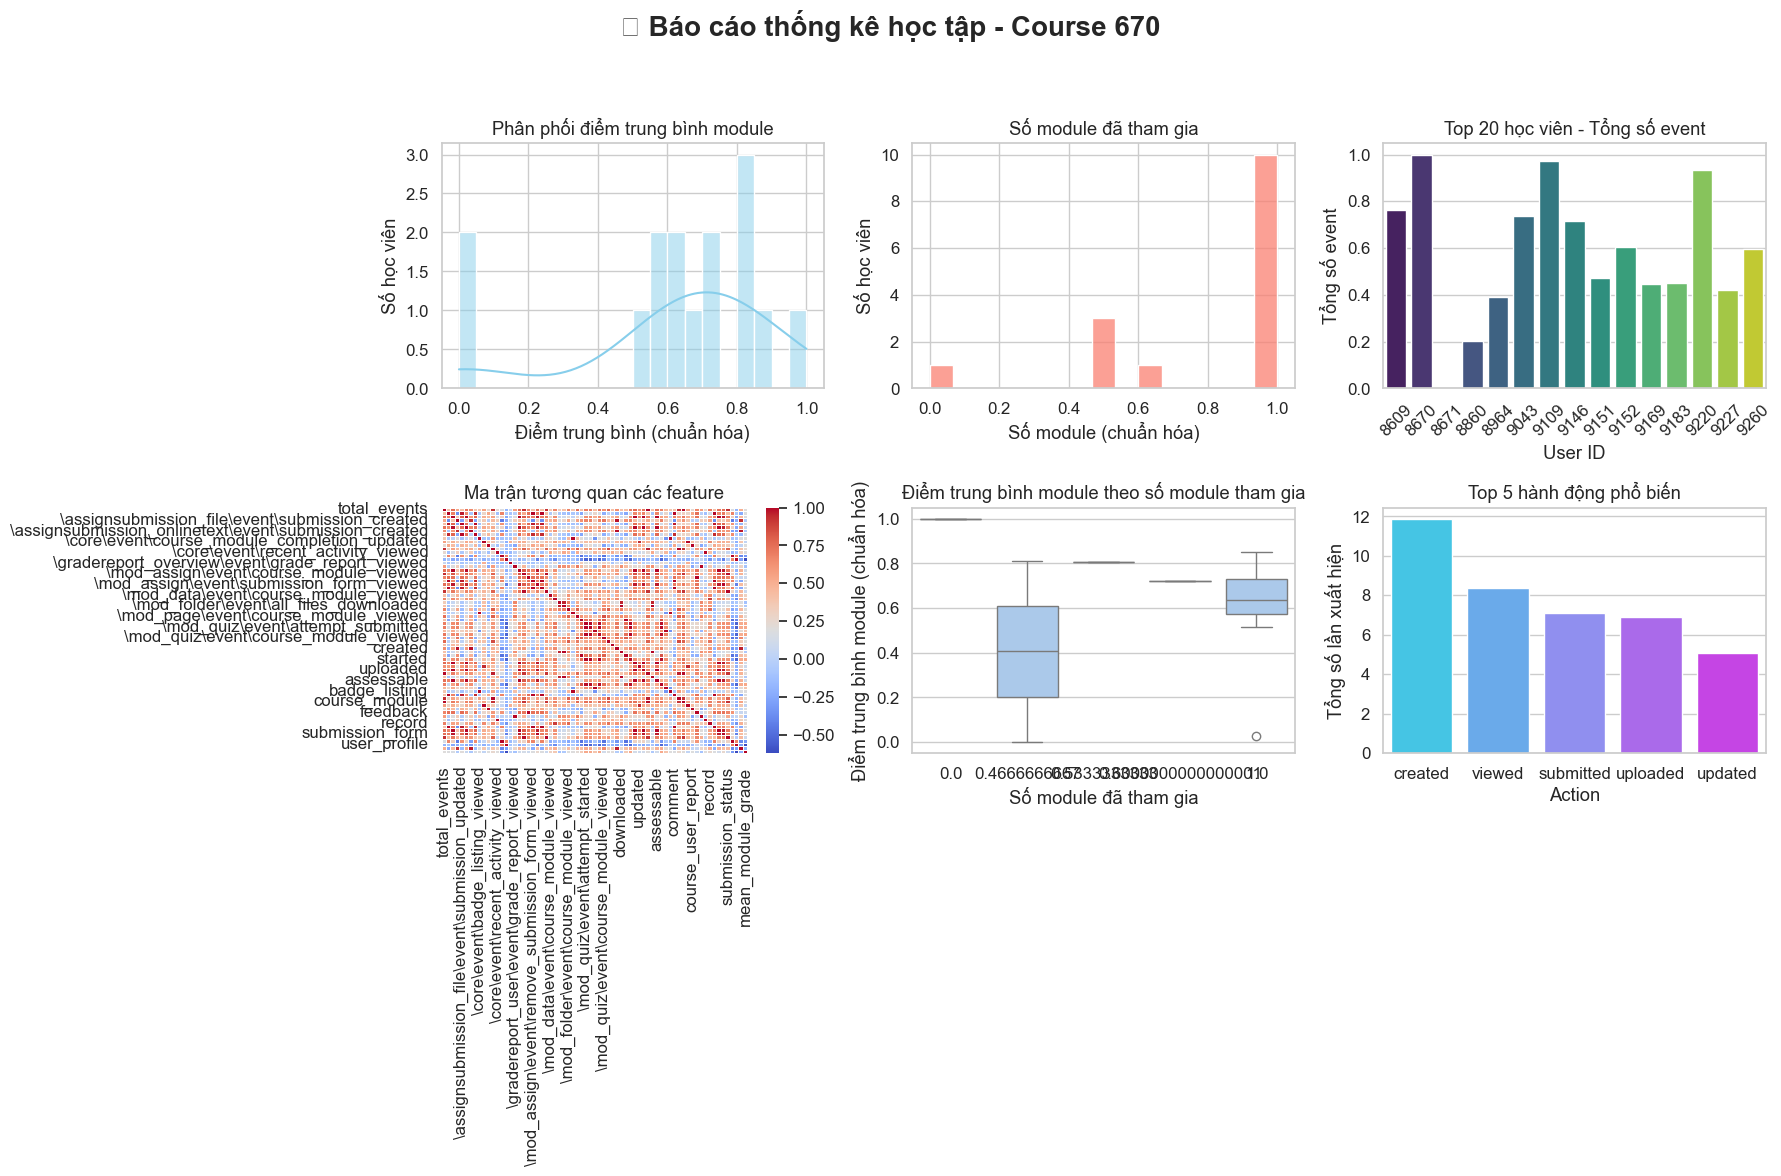

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Đọc dữ liệu đã chuẩn hóa
# -----------------------------
features_scaled = pd.read_json('../data/features_scaled_report.json')

# -----------------------------
# Cấu hình chung cho biểu đồ
# -----------------------------
sns.set(style='whitegrid', palette='pastel', font_scale=1.1)
plt.rcParams['figure.figsize'] = (18, 12)

# -----------------------------
# Tạo figure với nhiều subplot
# -----------------------------
fig, axes = plt.subplots(2, 3)  # 2 hàng, 3 cột
fig.suptitle('📊 Báo cáo thống kê học tập - Course 670', fontsize=20, fontweight='bold')

# 1️⃣ Phân phối điểm trung bình module
sns.histplot(features_scaled['mean_module_grade'], bins=20, kde=True, ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Phân phối điểm trung bình module')
axes[0,0].set_xlabel('Điểm trung bình (chuẩn hóa)')
axes[0,0].set_ylabel('Số học viên')

# 2️⃣ Phân phối số module đã tham gia
sns.histplot(features_scaled['module_count'], bins=15, ax=axes[0,1], color='salmon')
axes[0,1].set_title('Số module đã tham gia')
axes[0,1].set_xlabel('Số module (chuẩn hóa)')
axes[0,1].set_ylabel('Số học viên')

# 3️⃣ Top 20 học viên theo tổng số event
top_users = features_scaled.sort_values('total_events', ascending=False).head(20)
sns.barplot(x='userid', y='total_events', data=top_users, palette='viridis', ax=axes[0,2])
axes[0,2].set_title('Top 20 học viên - Tổng số event')
axes[0,2].set_xlabel('User ID')
axes[0,2].set_ylabel('Tổng số event')
axes[0,2].tick_params(axis='x', rotation=45)

# 4️⃣ Heatmap tương quan các feature
sns.heatmap(features_scaled.drop(columns=['userid']).corr(), annot=False, cmap='coolwarm', linewidths=0.5, ax=axes[1,0])
axes[1,0].set_title('Ma trận tương quan các feature')

# 5️⃣ Boxplot: Điểm trung bình vs số module
sns.boxplot(x='module_count', y='mean_module_grade', data=features_scaled, ax=axes[1,1])
axes[1,1].set_title('Điểm trung bình module theo số module tham gia')
axes[1,1].set_xlabel('Số module đã tham gia')
axes[1,1].set_ylabel('Điểm trung bình module (chuẩn hóa)')


# 6️⃣ Phân phối số lần từng action (top 5 action phổ biến)
action_cols = ['viewed','updated','uploaded','created','submitted']  # ví dụ các cột action đã chuẩn hóa
if all(col in features_scaled.columns for col in action_cols):
    action_data = features_scaled[action_cols]
    action_data = action_data.sum().sort_values(ascending=False)
    sns.barplot(x=action_data.index, y=action_data.values, ax=axes[1,2], palette='cool')
    axes[1,2].set_title('Top 5 hành động phổ biến')
    axes[1,2].set_xlabel('Action')
    axes[1,2].set_ylabel('Tổng số lần xuất hiện')
    
    
# -----------------------------
# Tối ưu hiển thị
# -----------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_87978/3765060218.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


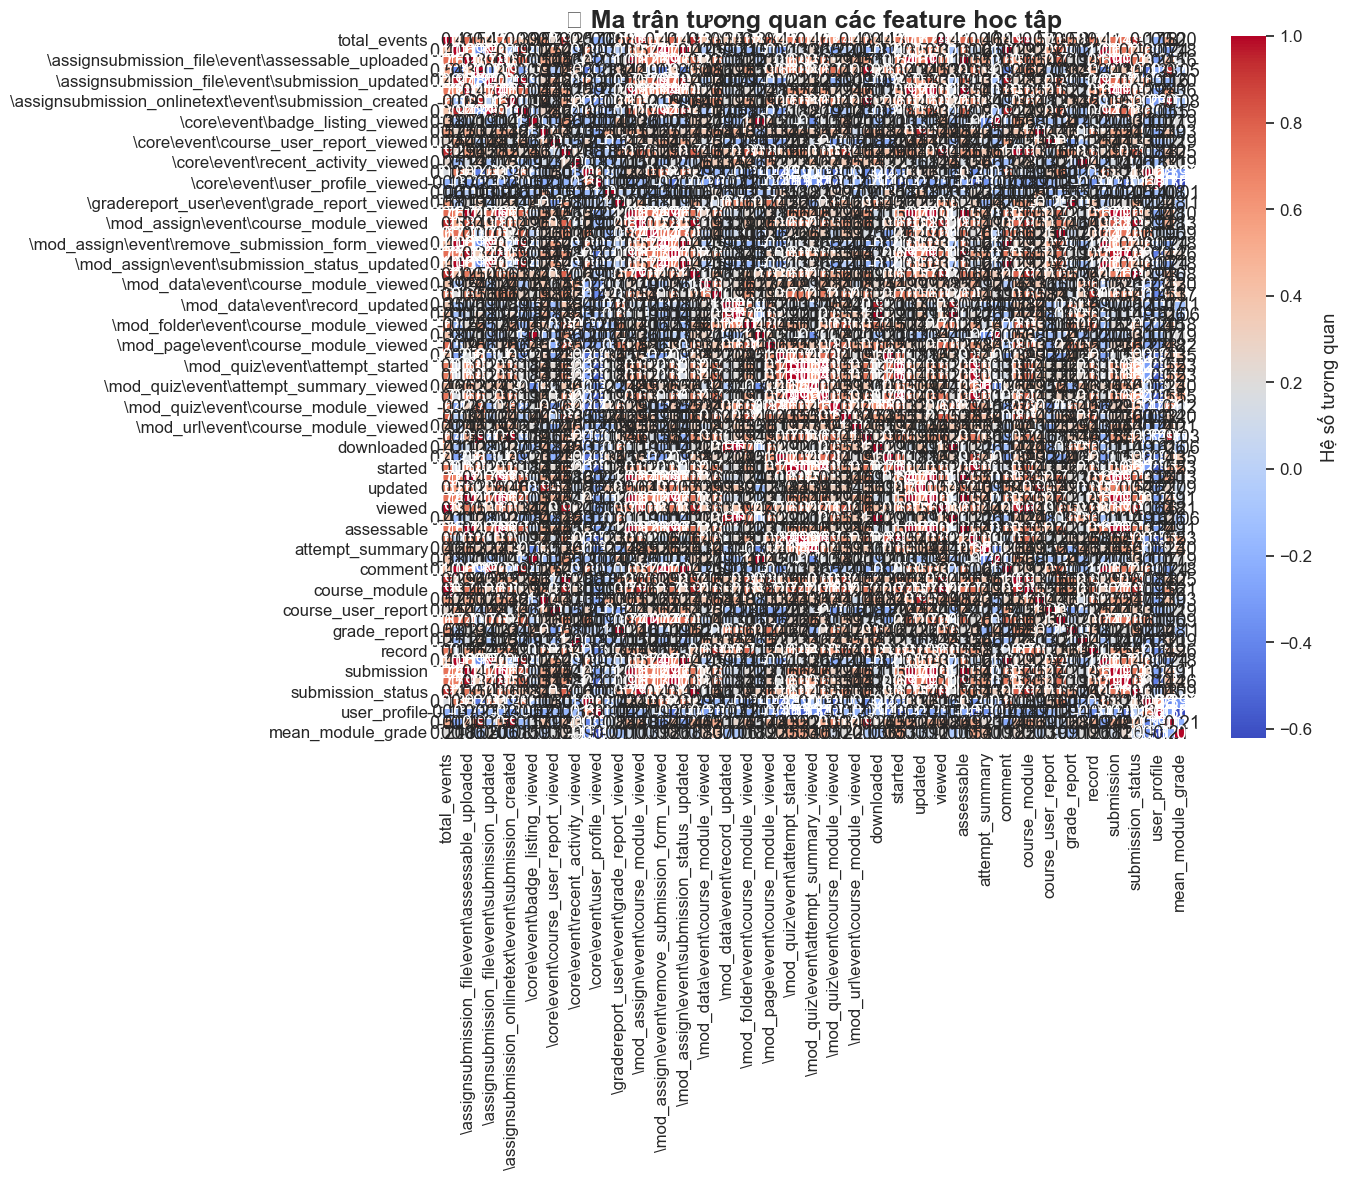

In [9]:
# -----------------------------
# Tạo ma trận tương quan
# -----------------------------
corr_matrix = features_scaled.drop(columns=['userid']).corr()

# -----------------------------
# Vẽ heatmap riêng cho ma trận tương quan
# -----------------------------
plt.figure(figsize=(14,12))
sns.set(style='whitegrid', font_scale=1.1)

sns.heatmap(
    corr_matrix, 
    annot=True,          # Hiển thị giá trị tương quan
    fmt=".2f",           # Định dạng số
    cmap='coolwarm',     # Màu sắc
    linewidths=0.5,
    cbar_kws={'label': 'Hệ số tương quan'}
)

plt.title('📊 Ma trận tương quan các feature học tập', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()